---
title: piccard
subtitle: Current Version:\ 0.0.1
author: Maliha Lodi
format: 
    html:
        code-fold: false
execute:
    enabled: false
---

**piccard** is a Python package which provides an alternative framework to traditional harmonization techniques for combining spatial data with inconsistent geographic units across multiple years. It uses a network representation containing nodes and edges to retain all information available in the data. Nodes are used to represent all the geographic areas (e.g., census tracts, dissemination areas) for each year. An edge connects two nodes when the geographic area corresponding to the tail node has at least a 5% area overlap with the geographic area corresponding to the head node in the previous available year.

The method behind this package can be found in the following research paper [(link)](https://doi.org/10.31235/osf.io/a3gtd)  
Dias, F., & Silver, D. (2018). Visualizing demographic evolution using geographically inconsistent census data. California Digital Library (CDL). https://doi.org/10.31235/osf.io/a3gtd

### Setup
<hr>

In [128]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
ct_2006 = gpd.read_file("data/gct_000b06a_e/gct_000b06a_e.shp")
ct_2011 = gpd.read_file("data/gct_000b11a_e/gct_000b11a_e.shp")
ct_2016 = gpd.read_file("data/lct_000b16a_e/lct_000b16a_e.shp")
ct_2021 = gpd.read_file("data/lct_000b21a_e/lct_000b21a_e.shp")

### Useful Functions
<hr>

#### piccard.preprocessing
**piccard.preprocessing(ct_data, year, id)**  
Return a cleaned GeoDataFrame of the input data with a new column showing the area of each census tract.  
<hr>

**Parameters:**  
ct_data : *GeoDataFrame*  
year : *string*  
id : *string*  

**Notes:**  
- Input data is assumed to have been passed through `gpd.read_file()` beforehand  
<hr>

In [4]:
def preprocessing(ct_data, year, id):
    process_data = ct_data.copy()
    
    #Suppressing CRS warning associated with .buffer() 
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=UserWarning)
        process_data['geometry'] = (process_data.to_crs('EPSG:4246').geometry
                                    .buffer(-0.000001))
        process_data['area' + '_' + year] = process_data.area
    process_data[id] = year + '_' + process_data[id]
        
    return process_data

#### Example

In [12]:
from piccard import piccard as pc

ct_2006 = gpd.read_file("data/gct_000b06a_e/gct_000b06a_e.shp")
clean_data = pc.preprocessing(ct_2006, '2006', 'CTUID')

In [13]:
ct_2006.head(5)

,CTUID,CMAUID,PRUID,geometry
0,0010001.00,001,10,"POLYGON ((-52.68954 47.53004, -52.68960 47.529..."
1,0010002.00,001,10,"POLYGON ((-52.71822 47.54844, -52.71799 47.548..."
2,0010003.01,001,10,"POLYGON ((-52.74120 47.52964, -52.74126 47.529..."
3,0010003.02,001,10,"POLYGON ((-52.74526 47.52948, -52.74627 47.529..."
4,0010004.00,001,10,"POLYGON ((-52.74217 47.56288, -52.74140 47.561..."


In [14]:
clean_data.head(5)

,CTUID,CMAUID,PRUID,geometry,area_2006
0,2006_0010001.00,001,10,"POLYGON ((-52.68954 47.53004, -52.68961 47.529...",0.001230
1,2006_0010002.00,001,10,"POLYGON ((-52.71822 47.54843, -52.71799 47.548...",0.000234
2,2006_0010003.01,001,10,"POLYGON ((-52.74120 47.52965, -52.74126 47.529...",0.000194
3,2006_0010003.02,001,10,"POLYGON ((-52.74527 47.52948, -52.74627 47.529...",0.000232
4,2006_0010004.00,001,10,"POLYGON ((-52.74217 47.56288, -52.74141 47.561...",0.001105


<hr>

#### piccard.create_network

**piccard.create_network(census_dfs, years, id, threshold=0.05)**  
Creates a network representation of the temporal connections present in *census_dfs* over *years* when each yearly geographic area has at most *threshold* percentage of overlap with its corresponding area(s) in the next year.
<hr>

**Parameters:**  
census_dfs : *List\[GeoDataFrame\]*  
years: *List\[string\]*  
id: *string*  
threshold: *float*
<hr>

In [ ]:
def create_network(census_dfs, years, id, threshold=0.05):
    preprocessed_dfs = [preprocessing(census_dfs[i], years[i], id) 
                        for i in range(len(census_dfs))]
    contained_cts = ct_containment(preprocessed_dfs, years) 

    nodes = get_nodes(contained_cts, id, threshold)
    attributes = get_attributes(nodes, census_dfs, years, id)

    G = nx.from_pandas_edgelist(nodes, f'{id}_1', f'{id}_2')
    nx.set_node_attributes(G, attributes.set_index(id).to_dict('index'))
    
    return G

#### Example

In [ ]:
from piccard import piccard as pc

years = ['2011', '2016', '2021']
census_dfs = [ct_2011, ct_2016, ct_2021]

G = pc.create_network(census_dfs, years, 'CTUID', 0.05)

In [ ]:
list(G.nodes(data=True))[:2]

[('2011_0010001.00',
  {'CTNAME': '0001.00',
   'CMAUID': '001',
   'CMANAME': "St. John's",
   'CMATYPE': 'B',
   'CMAPUID': '10001',
   'PRUID': '10',
   'PRNAME': 'Newfoundland and Labrador / Terre-Neuve-et-Labrador',
   'DGUID': nan,
   'LANDAREA': nan,
   'network_level': 1}),
 ('2016_0010001.00',
  {'CTNAME': '0001.00',
   'CMAUID': '001',
   'CMANAME': "St. John's",
   'CMATYPE': 'B',
   'CMAPUID': '10001',
   'PRUID': '10',
   'PRNAME': 'Newfoundland and Labrador / Terre-Neuve-et-Labrador',
   'DGUID': nan,
   'LANDAREA': nan,
   'network_level': 2})]

In [ ]:
list(G.edges(data=True))[:2]

[('2011_0010001.00', '2016_0010001.00', {}),
 ('2016_0010001.00', '2021_0010001.00', {})]

<hr>

#### piccard.create_network_table

**piccard.create_network_table(census_dfs, years, id, threshold=0.05)**  
Return the final network table with all the temporal connections present in *census_dfs* over *years* when each yearly geographic area has at most *threshold* percentage of overlap with its corresponding area(s) in the next year.
<hr>

**Parameters:**  
census_dfs : *List\[DataFrame\]*  
years: *List\[string\]*  
id: *string*  
threshold: *float*

**Notes:**  
- The resulting table contains the same information as the network created in `piccard.create_network()`
<hr>

In [ ]:
def create_network_table(census_dfs, years, id, threshold=0.05): 
    num_years = len(years)
    num_joins = math.ceil(num_years/2) 
    final_cols = ['ct_' + col_name for col_name in years]
    network_table = pd.DataFrame()
    drop_cols = final_cols[1:]

    preprocessed_dfs = [preprocessing(census_dfs[i], years[i], id) 
                        for i in range(len(census_dfs))]
    contained_cts = ct_containment(preprocessed_dfs, years) 
    nodes = get_nodes(contained_cts, id, threshold)
    
    #all_paths returns a three item tuple
    all_paths = find_all_paths(nodes, num_joins, id)
    all_paths_df = all_paths[0]
    left_cols = all_paths[1]
    right_cols = all_paths[2]
    
    #Dividing all network paths into full paths and partial paths 
    na_df = all_paths_df[all_paths_df.isnull().any(axis=1)] 
    no_na_df = all_paths_df[~all_paths_df.isnull().any(axis=1)] 
    
    full_paths = find_full_paths(no_na_df, final_cols)
    full_paths_list = full_paths.to_numpy().flatten()
    
    partial_paths = find_partial_paths(na_df, years, left_cols, final_cols, full_paths_list)
    
    network_table = pd.concat([full_paths, partial_paths])
    network_table = network_table[final_cols]
    network_table = network_table.T.drop_duplicates().T 
    network_table = network_table.drop_duplicates(subset=drop_cols, keep='last')
    network_table.sort_values(by=final_cols[0], ignore_index=True)
    
    attributes = get_attributes(nodes, census_dfs, years, id)
    final_table = attach_attributes(network_table, attributes, years, final_cols, id)
    
    #Formatting final table columns
    for i in range(len(final_cols)):
        col = str(final_cols[i])
        popped = final_table.pop(col) 
        final_table.insert(i, popped.name, popped)
    final_table.columns= final_table.columns.str.lower()
        
    return final_table

### Example

In [ ]:
from piccard import piccard as pc

census_dfs = [ct_2011, ct_2016, ct_2021]
years = ['2011', '2016', '2021']

network_table = pc.create_network_table(census_dfs, years, 'CTUID')

In [ ]:
network_table

,ct_2011,ct_2016,ct_2021,ctname_2011,cmauid_2011,cmaname_2011,cmatype_2011,cmapuid_2011,pruid_2011,prname_2011,...,cmatype_2016,cmapuid_2016,pruid_2016,prname_2016,network_level_2016,ctname_2021,pruid_2021,dguid_2021,landarea_2021,network_level_2021
0,NaN,3050120.00,3050120.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,B,13305,13,New Brunswick / Nouveau-Brunswick,2,0120.00,13,2021S05073050120.00,149.1445,3
1,NaN,3100140.00,3100140.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,B,13310,13,New Brunswick / Nouveau-Brunswick,2,0140.00,13,2021S05073100140.00,144.7702,3
2,NaN,3200028.00,3200028.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,K,13320,13,New Brunswick / Nouveau-Brunswick,2,0028.00,13,2021S05073200028.00,29.4354,3
3,NaN,3200029.00,3200029.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,K,13320,13,New Brunswick / Nouveau-Brunswick,2,0029.00,13,2021S05073200029.00,527.2040,3
4,NaN,3200030.00,3200030.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,K,13320,13,New Brunswick / Nouveau-Brunswick,2,0030.00,13,2021S05073200030.00,294.3542,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6339,9700100.00,9700100.00,9700100.00,0100.00,970,Prince George,K,59970,59,British Columbia / Colombie-Britannique,...,K,59970,59,British Columbia / Colombie-Britannique,2,0100.00,59,2021S05079700100.00,12487.2890,3
6340,9700101.00,9700101.00,9700101.00,0101.00,970,Prince George,K,59970,59,British Columbia / Colombie-Britannique,...,K,59970,59,British Columbia / Colombie-Britannique,2,0101.00,59,2021S05079700101.00,667.6134,3
6341,9700102.00,9700102.00,9700102.00,0102.00,970,Prince George,K,59970,59,British Columbia / Colombie-Britannique,...,K,59970,59,British Columbia / Colombie-Britannique,2,0102.00,59,2021S05079700102.00,2802.3279,3
6342,9700103.00,9700103.01,9700103.01,0103.00,970,Prince George,K,59970,59,British Columbia / Colombie-Britannique,...,K,59970,59,British Columbia / Colombie-Britannique,2,0103.01,59,2021S05079700103.01,5.2340,3


<hr>

#### piccard.draw_subnetwork

**piccard.draw_subnetwork(network_table, G, num_cts=4)**  
Draws a subgraph of the network representation where num_cts is the number of census tracts in the first census year which are followed through all census years.
<hr>

**Parameters:**  
network_table : *DataFrame*  
G: *NetworkX Graph*  
num_cts: *int*

**Notes:**  
- The network_table and graph G is required to be generated first before using this function. 
- A larger num_cts value may result in an unorganized and hard-to-read visualization.
<hr>

In [ ]:
def draw_subnetwork(network_table, G, num_cts=4):
  """
  Draws a subgraph of the network representation where num_cts is the
  number of census tracts in the first census year which are followed through
  all census years.

  Note: A large num_cts value may result in an unorganized and hard-to-read
        visualization. 
  """
  r = re.compile('ctuid_[0-9]+')

  table_cols = list(network_table.columns)
  sample_cols = list(filter(r.match, table_cols))

  #Sampling n nodes from the first year
  ct_ids = network_table[sample_cols]
  first_year_mask = network_table.iloc[:, 0].notnull()
  first_year_sample = ct_ids.iloc[:, 0][first_year_mask].sample(num_cts)

  #Selecting all connections beginning with sample nodes from first year
  ct_sample = ct_ids[ct_ids.iloc[:, 0].isin(first_year_sample)]

  sample_nodes = []
  
  #Adding corresponding year prefix to all nodes for labels and collecting all 
  #visualization nodes in a single list
  for i in range(len(sample_cols)):
    curr_col = sample_cols[i]
    curr_nodes = sample_cols[i][6:] + '_' + ct_sample.loc[:, curr_col]
    sample_nodes.append(curr_nodes)

  sample_nodes = pd.concat(sample_nodes, axis=0, sort=True, ignore_index=True)

  subgraph = G.subgraph(sample_nodes)

  #Calculating the figure size based on the number of nodes
  num_nodes = len(subgraph)
  fig_width = max(10, num_nodes * 0.2)  # Minimum figure width of 10
  fig_height = max(5, num_nodes * 0.2)  # Minimum figure height of 5
  
  plt.figure(figsize=(fig_width, fig_height))
  pos = nx.multipartite_layout(subgraph, subset_key='network_level')

  nx.draw(subgraph, pos, with_labels=True, node_size=300, node_color='orange')
  plt.show()

### Example

In [ ]:
from piccard import piccard as pc

network_table = pc.create_network_table(census_dfs, years, 'CTUID', 0.05)
G = pc.create_network(census_dfs, years, 'CTUID', 0.05)

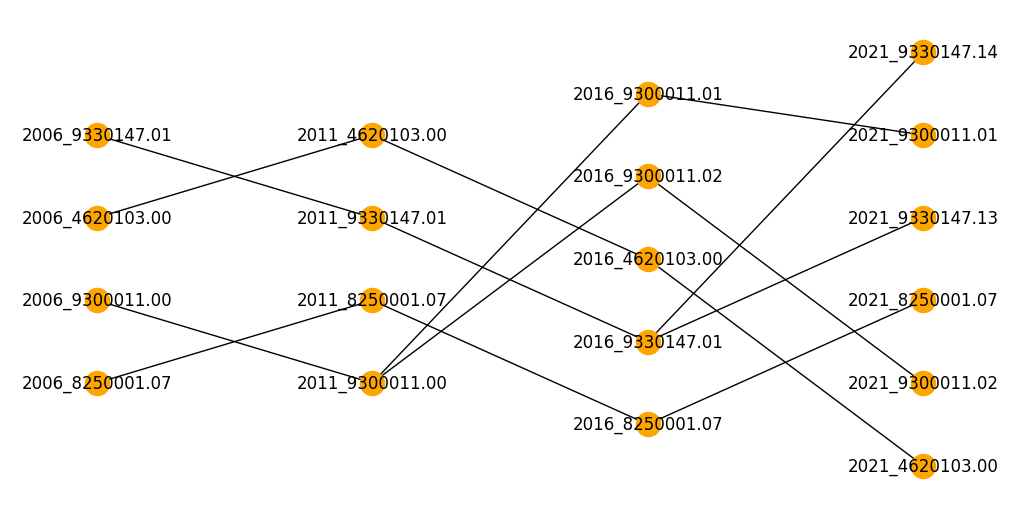

In [ ]:
pc.draw_subnetwork(network_table, G)

<hr>

#### piccard.plot_num_cts

**piccard.plot_num_cts(network_table, years, id)**  
Plots the number of census tracts across all given census years.
<hr>

**Parameters:**  
network_table : *DataFrame*  
years: *List[str]*  
id: *str*

<hr>

In [ ]:
def plot_num_cts(network_table, years, id):
  '''
  Plots the number of census tracts across all given census years.
  '''
  num_years = len(years)
  ct_df = network_table.iloc[:, :num_years]
  ct_per_year = list(ct_df.apply(lambda x: x.notnull().sum()))

  plt.plot(years, ct_per_year)
  plt.title(f'Number of {id}s across all census years')
  plt.xlabel('Year')
  plt.ylabel(f'Number of {id}s')
  plt.show()

### Example

In [ ]:
from piccard import piccard as pc

network_table = pc.create_network_table(census_dfs, years, 'CTUID', 0.05)

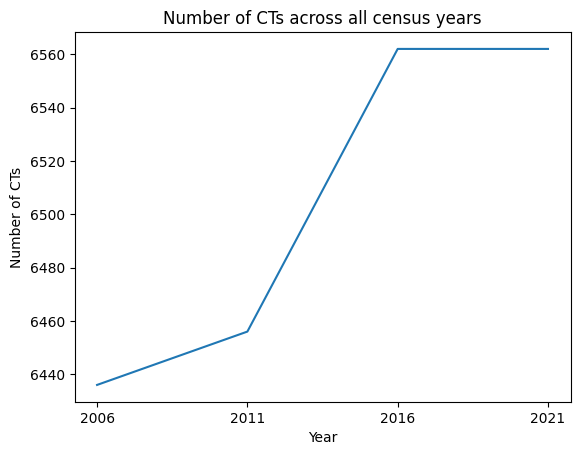

In [ ]:
pc.plot_num_cts(network_table, years, 'CT')

<hr>

### Background Functions

<hr>

#### piccard.ct_containment

**piccard.preprocessing(preprocessed_dfs, years)**  
Return a List of GeoDataFrames with census tracts that are geographically contained within census tracts from the following census year. Every ith list element (ith GeoDataFrame) includes the ith year census tracts that are contained within the i+1th year census tracts. 
<hr>

**Parameters:**  
preprocessed_dfs : *List\[GeoDataFrame\]*  
years : *List\[string\]*  

**Notes:**  
- The order of elements in both lists in terms of the census year correspond to one other.  
- Input data is preprocessed before calling this function.  
<hr>

In [5]:
def ct_containment(preprocessed_dfs, years):
    num_years = len(years)
    contained_tracts = []
    
    for i in range(num_years-1):
        #Getting CTs which are contained within a previous year's CT
        contained_df = gpd.overlay(preprocessed_dfs[i], preprocessed_dfs[i+1],
                                   how='intersection')
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=UserWarning)
            
            contained_df['area_intersection'] = contained_df.area
            #Calculating the percentage of the overlapping area between the 2 years
            pct_col = 'pct_' + years[i+1] + '_of_' + years[i]
            contained_df[pct_col] = (contained_df['area_intersection'] /
                                     contained_df[['area_'+years[i],
                                                   'area_'+years[i+1]]].min(axis=1))
        contained_tracts.append(contained_df)
    return contained_tracts

#### Example

In [6]:
from piccard import piccard as pc 

ct_2011 = gpd.read_file("data/gct_000b11a_e/gct_000b11a_e.shp")
ct_2016 = gpd.read_file("data/lct_000b16a_e/lct_000b16a_e.shp")
ct_2021 = gpd.read_file("data/lct_000b21a_e/lct_000b21a_e.shp")
years = ['2011', '2016', '2021']
census_dfs = [ct_2011, ct_2016, ct_2021]

preprocessed_dfs = [pc.preprocessing(census_dfs[i], years[i], 'CTUID') 
                    for i in range(len(census_dfs))]

contained = pc.ct_containment(preprocessed_dfs, years)

In [41]:
contained[0].head(5)

,CTUID_1,CTNAME_1,CMAUID_1,CMANAME_1,CMATYPE_1,CMAPUID_1,PRUID_1,PRNAME_1,area_2011,CTUID_2,...,PRUID_2,PRNAME_2,CMAUID_2,CMAPUID_2,CMANAME_2,CMATYPE_2,area_2016,geometry,area_intersection,pct_2016_of_2011
0,2011_5550021.00,0021.00,555,London,B,35555,35,Ontario,0.000237,2016_5550043.00,...,35,Ontario,555,35555,London,B,0.000202,"POLYGON ((-81.26066 42.99321, -81.26110 42.993...",3.981324e-09,0.000020
1,2011_5550034.00,0034.00,555,London,B,35555,35,Ontario,0.000148,2016_5550043.00,...,35,Ontario,555,35555,London,B,0.000202,"MULTIPOLYGON (((-81.25322 42.99553, -81.25102 ...",1.105083e-07,0.000748
2,2011_5550043.00,0043.00,555,London,B,35555,35,Ontario,0.000201,2016_5550043.00,...,35,Ontario,555,35555,London,B,0.000202,"POLYGON ((-81.24889 42.99678, -81.24963 42.996...",2.013663e-04,0.999699
3,2011_5550042.00,0042.00,555,London,B,35555,35,Ontario,0.000148,2016_5550043.00,...,35,Ontario,555,35555,London,B,0.000202,"MULTIPOLYGON (((-81.24929 42.99897, -81.24965 ...",2.051036e-08,0.000138
4,2011_5550045.00,0045.00,555,London,B,35555,35,Ontario,0.000200,2016_5550043.00,...,35,Ontario,555,35555,London,B,0.000202,"MULTIPOLYGON (((-81.25534 43.00820, -81.25534 ...",7.485081e-09,0.000037


In [20]:
len(contained)

2

<hr>

#### piccard.get_nodes

**piccard.get_nodes(contained_tracts_df, id, threshold)**  
Return a GeoDataFrame with the graph connections between two census tracts of different years. Each row corresponds to one edge in the final network.
<hr>

**Parameters:**  
contained_tracts_df : *List\[GeoDataFrame\]*  
id: *string*  
threshold : *float*
<hr>

In [6]:
def get_nodes(contained_tracts_df, id, threshold=0.05):
    nodes = gpd.GeoDataFrame()
    id_cols = [f'{id}_1', f'{id}_2']
    
    #Aggregating overlapped percentage area for all unique CTs 
    for i in range(len(contained_tracts_df)):
        pct_col = contained_tracts_df[i].iloc[:, -1].name
        year_pct = (contained_tracts_df[i]
                    .groupby(id_cols)
                    .agg({f'{pct_col}': 'sum'}) 
                    .reset_index()
                   )
        
        #Selecting CTs with an overlapped area above user's threshold
        connected_cts = year_pct[year_pct[pct_col] >= threshold][id_cols]
        nodes = pd.concat([nodes, connected_cts], axis=0, ignore_index=True)
        
    return nodes

#### Example

In [8]:
from piccard import piccard as pc

years = ['2011', '2016', '2021']
census_dfs = [ct_2011, ct_2016, ct_2021]

preprocessed_dfs = [pc.preprocessing(census_dfs[i], years[i], 'CTUID') 
                    for i in range(len(census_dfs))]
contained = pc.ct_containment(preprocessed_dfs, years)
nodes = pc.get_nodes(contained, 'CTUID', 0.05)

In [9]:
nodes.head(5)

,CTUID_1,CTUID_2
0,2011_0010001.00,2016_0010001.00
1,2011_0010002.00,2016_0010002.00
2,2011_0010003.01,2016_0010003.01
3,2011_0010003.02,2016_0010003.02
4,2011_0010004.00,2016_0010004.00


<hr>

#### piccard.assign_node_level

**piccard.assign_node_level(row, years, id)**  
Assign the level of a node in the network based on its relative year in the overall network.
<hr>

**Parameters:**  
row : *DataFrame row*  
years : *List\[string\]*  
id: *string*
<hr>

In [7]:
def assign_node_level(row, years, id):
    for i in range(len(years)):
        if row[id].startswith(str(years[i])):
            return i+1

<hr>

#### piccard.get_attributes

**piccard.get_attributes(nodes, census_dfs, years, id)**  
Returns all the attributes in the original data relating to the corresponding network nodes for the given year(s)
<hr>

**Parameters:**  
nodes : *DataFrame*  
census_dfs: *List[GeoDataFrame]*  
years : *List[string]*  
id: *string*
<hr>

In [8]:
def get_attributes(nodes, census_dfs, years, id):
    #Condensing nodes into single column df
    single_nodes = pd.concat([nodes[col] for col in nodes]).reset_index(drop=True)
    single_nodes_df = pd.DataFrame({id: single_nodes})
    attr = []
    
    for i in range(len(census_dfs)):
        #Adding year as a prefix for the merge 
        curr_df_id = census_dfs[i].loc[:, id]
        curr_df_id = years[i] + '_' + curr_df_id
        
        #Removing geometry column in attributes for the final table 
        year_attr = census_dfs[i].loc[:, (census_dfs[i].columns != 'geometry')].copy()
        year_attr[id] = curr_df_id
        year_attr = pd.merge(single_nodes_df, year_attr, on=id, how='right')
        
        attr.append(year_attr)
    all_attr = (pd.concat(attr)).drop_duplicates(subset=id)
    all_attr = all_attr[all_attr[id].notna()]
    
    #Assigning each node it's level in the network (used for mainly drawing)
    all_attr['network_level'] = all_attr.apply(lambda x: assign_node_level(x, years, id), 
                                               axis=1)
    return all_attr

#### Example

In [14]:
from piccard import piccard as pc

years = ['2011', '2016', '2021']
census_dfs = [ct_2011, ct_2016, ct_2021]

preprocessed_dfs = [pc.preprocessing(census_dfs[i], years[i], 'CTUID') 
                    for i in range(len(census_dfs))]
contained = pc.ct_containment(preprocessed_dfs, years)
nodes = pc.get_nodes(contained, 'CTUID', 0.05)

attributes = pc.get_attributes(nodes, census_dfs, years, 'CTUID')

In [15]:
# Note that columns will be populated based on the original input files
# i.e., The input file for 2021 doesn't have 'LANDAREA', leading to the NaN column below
attributes.head(5)

,CTUID,CTNAME,CMAUID,CMANAME,CMATYPE,CMAPUID,PRUID,PRNAME,DGUID,LANDAREA,network_level
0,2011_5550021.00,0021.00,555,London,B,35555,35,Ontario,NaN,NaN,1
1,2011_5410010.00,0010.00,541,Kitchener - Cambridge - Waterloo,B,35541,35,Ontario,NaN,NaN,1
2,2011_5350091.02,0091.02,535,Toronto,B,35535,35,Ontario,NaN,NaN,1
3,2011_5800161.01,0161.01,580,Greater Sudbury / Grand Sudbury,B,35580,35,Ontario,NaN,NaN,1
4,2011_2050120.00,0120.00,205,Halifax,B,12205,12,Nova Scotia / Nouvelle-Écosse,NaN,NaN,1


<hr>

#### piccard.find_all_paths

**piccard.find_all_paths(nodes_df, num_joins, id)**  
Return all possible paths present in the input data.
<hr>

**Parameters:**  
nodes_df : *DataFrame*  
num_joins: *int*  
id: *string*

**Notes:**  
- The resulting dataframe is **not** organized, and does contain duplicate entries in both the rows and columns. It is not recommended to use this function to analyze the temporal connections. It is **only** used as an intermediate step when creating the final network table.  
- num_joins is calculated by another function when creating the final network table
<hr>

In [10]:
def find_all_paths(nodes_df, num_joins, id):
    left_cols = [f'{id}_1_x', f'{id}_2_x']
    right_cols = [f'{id}_1_y', f'{id}_1_x']

    #Merging network nodes num_joins amount of times to ensure all paths are found  
    curr_join = nodes_df.merge(nodes_df, how='left', left_on=f'{id}_1', right_on=f'{id}_2')
    curr_join = curr_join.sort_values(by=[f'{id}_1_y', f'{id}_2_y'], ignore_index=True)
    
    if num_joins > 1:
        for i in range(num_joins - 1):
            curr_join = curr_join.merge(curr_join, how='left', 
                                        left_on=left_cols, right_on=right_cols, 
                                        suffixes=['x', 'y'])
            
            #Accounting for the new column names after the merge
            left_cols = [col_name + 'x' for col_name in left_cols]
            right_cols = [col_name + 'x' for col_name in right_cols]
            
    return (curr_join, left_cols, right_cols)

### Example

In [11]:
from piccard import piccard as pc

years = ['2011', '2016', '2021']
census_dfs = [ct_2011, ct_2016, ct_2021]

preprocessed_dfs = [pc.preprocessing(census_dfs[i], years[i], 'CTUID') 
                    for i in range(len(census_dfs))]
contained = pc.ct_containment(preprocessed_dfs, years)
nodes = pc.get_nodes(contained, 'CTUID', 0.05)

In [12]:
all_paths = pc.find_all_paths(nodes, 2, 'CTUID')

In [14]:
all_paths[0].head(5)

,CTUID_1_xx,CTUID_2_xx,CTUID_1_yx,CTUID_2_yx,CTUID_1_xy,CTUID_2_xy,CTUID_1_yy,CTUID_2_yy
0,2016_0010001.00,2021_0010001.00,2011_0010001.00,2016_0010001.00,NaN,NaN,NaN,NaN
1,2016_0010002.00,2021_0010002.00,2011_0010002.00,2016_0010002.00,NaN,NaN,NaN,NaN
2,2016_0010003.01,2021_0010003.01,2011_0010003.01,2016_0010003.01,NaN,NaN,NaN,NaN
3,2016_0010003.02,2021_0010003.02,2011_0010003.02,2016_0010003.02,NaN,NaN,NaN,NaN
4,2016_0010004.00,2021_0010004.01,2011_0010004.00,2016_0010004.00,NaN,NaN,NaN,NaN


In [15]:
[all_paths[1], all_paths[2]]

[['CTUID_1_xx', 'CTUID_2_xx'], ['CTUID_1_yx', 'CTUID_1_xx']]

<hr>

#### piccard.find_full_paths

**piccard.find_full_paths(full_paths_df, final_cols)**  
Return all full paths present in input data.
<hr>

**Parameters:**  
full_paths_df: *DataFrame*  
final_cols: *List[string]*  

**Notes:**  
- A full path is defined as a path in the network where the starting node is from the first input year and the ending node is from the last input year (i.e., a path which spans the year network).  
<hr>

In [11]:
def find_full_paths(full_paths_df, final_cols):
    full_paths = pd.DataFrame()
    
    if (not full_paths_df.empty):
        full_paths = full_paths_df.T.drop_duplicates().sort_values(by=0).T
        full_paths.columns = final_cols
    return full_paths

<hr>

#### piccard.first_year_partial_paths

**piccard.first_year_partial_paths(all_partial_paths, years, final_cols)**  
Return all partial paths only for the first input year.
<hr>

**Parameters:**  
all_partial_paths : *DataFrame*  
years: *List\[string\]*  
final_cols: *List\[string\]*

**Notes:**  
- A partial path is defined as a path in the network where the starting and ending nodes are of any year (i.e., a path which does **not** span the entire network, not a full path). 
<hr>

In [114]:
def first_year_partial_paths(all_partial_paths, years, final_cols):
    num_years = len(years)
    drop_cols = final_cols[1:]

    #Selecting paths with the starting node as the first year
    mask = all_partial_paths.iloc[:, 0].str.startswith(years[0] + '_')
    first_year_partials = all_partial_paths[mask]

    #Calculating which year contains the ending node 
    max_partial_year = max(all_partial_paths.T.stack().values)[:4]

    #Appending NaN columns to the end for each year as they don't exist in data
    if ((max_partial_year >= years[1]) & (max_partial_year != years[-1])):
        for i in reversed(range((num_years - 1) - max_partial_year)):
            last_col = len(first_year_partials.columns)
            first_year_partials.insert(last_col, final_cols[-i], np.NaN)
        first_year_partials.columns = final_cols 
    first_year_partials = first_year_partials.T.drop_duplicates().dropna().T
    first_year_partials.columns = final_cols
    
    return first_year_partials

<hr>

#### piccard.unique_partial_paths

**piccard.unique_partial_paths(all_partial_paths, years, left_cols, final_cols)**  
Return all unique partial paths between two consecutive input years.
<hr>

**Parameters:**  
all_partial_paths : *DataFrame*  
years: *List\[string\]*  
left_cols: *List\[string\]*  
final_cols: *List\[string\]*

**Notes:**  
- A partial path is defined as a path in the network where the starting and ending nodes are of any year (i.e., a path which does **not** span the entire network, not a full path). 
<hr>

In [ ]:
def unique_partial_paths(all_partial_paths, years, left_cols, final_cols):
    num_years = len(years)
    unique_partials = pd.DataFrame()
    
    for i in range(1, num_years):
        curr_year = years[i] + '_'
        prev_year = years[i-1] + '_'

        curr_year_mask = all_partial_paths.iloc[:, 0].str.startswith(curr_year)
        prev_year_mask = all_partial_paths.iloc[:, 0].str.startswith(prev_year)

        curr_year_partials = all_partial_paths[curr_year_mask]
        prev_year_partials = all_partial_paths[prev_year_mask]

        curr_year_mask = ~curr_year_partials[left_cols[0]].isin(prev_year_partials) 
        curr_year_unique = curr_year_partials[curr_year_mask]
        curr_year_unique = curr_year_partials.dropna(axis=1).T.drop_duplicates().T

    #Appending NaN column to the front to account for missing first year
        for k in range(i):
            curr_year_unique.insert(0, final_cols[k], np.NaN)

    #Appending NaN column to the end to account for missing last year
        if(not curr_year_unique.empty):
            curr_year_val = max(curr_year_unique.T.stack().values)[:4]
            curr_year_index = years.index(curr_year_val)

            if (curr_year_index != years[-1]):
                for j in range((num_years - 1) - curr_year_index):
                    last_col = len(curr_year_unique.columns)
                    curr_year_unique.insert(last_col, final_cols[-j], np.NaN)
                    
            curr_year_unique.columns = final_cols
        unique_partials = pd.concat([unique_partials, curr_year_unique])
    return unique_partials

<hr>

#### piccard.find_partial_paths

**piccard.find_partial_paths(partial_paths_df, years, left_cols, final_cols, exclude_nodes)**  
Return all partial paths present in input data.
<hr>

**Parameters:**  
partial_paths_df : *DataFrame*  
years: *List\[string\]*  
left_cols: *List\[string\]*  
final_cols: *List\[string\]*  
exclude_nodes: *DataFrame*

**Notes:**  
- A partial path is defined as a path in the network where the starting and ending nodes are of any year (i.e., a path which does **not** span the entire network, not a full path). 
<hr>

In [74]:
def find_partial_paths(partial_paths_df, years, left_cols, final_cols, exclude_nodes): 
    all_partial_paths = partial_paths_df.T.drop_duplicates().T 
    all_partial_paths = all_partial_paths[~all_partial_paths[left_cols[0]].isin(exclude_nodes)]
    
    first_year_partials = first_year_partial_paths(all_partial_paths, years, final_cols)
    unique_partials = unique_partial_paths(all_partial_paths, years, left_cols, final_cols)
    all_partials = pd.concat([unique_partials, first_year_partials])
    
    return all_partials

<hr>

#### piccard.attach_attributes

**piccard.attach_attributes(network_table, attributes, years, final_cols, id)**  
Return network table with attached attributes corresponding to the nodes involved.
<hr>

**Parameters:**  
network_table : *DataFrame*  
attributes: *DataFrame*  
years: *List\[string\]*  
final_cols: *List\[string\]*  
id: *string*
<hr>

In [80]:
def attach_attributes(network_table, attributes, years, final_cols, id):
    years_df_list = []

    for i in range(len(final_cols)):
        col = str(final_cols[i])
        
        #Getting attributes for each year
        table_col = network_table[col].to_frame().astype(object)
        curr_year = table_col.merge(attributes, how='left', left_on=col, right_on=id)
        curr_year = curr_year.drop([id], axis=1)
        
        #Suppressing warning for str.replace
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            curr_year = curr_year.apply(lambda x: x.str.replace(r'[0-9]+_', '') 
                                        if x.dtypes==object else x).reset_index(drop=True)
            
            #Formatting all columns as 'colname_year'
            curr_year_cols = [f'{col}_{years[i]}' 
                              if col != final_cols[i] and col != f'area_{years[i]}' 
                              else col for col in curr_year.columns]
            curr_year.columns = curr_year_cols
            years_df_list.append(curr_year)
            
    #Combining all years dfs into one
    network_table = (pd.concat(years_df_list, axis=1)).dropna(how='all', axis=1)
    return network_table